In [1]:
library(tidyverse)
library(repr)
library(tidymodels)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("data/OnlineNewsPopularity.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [7]:
set.seed(1234)
publishing_split <- initial_split(data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

named_data <- publishing_train %>%
    rename(
        Monday = weekday_is_monday,
        Tuesday = weekday_is_tuesday,
        Wednesday = weekday_is_wednesday,
        Thursday = weekday_is_thursday,
        Friday = weekday_is_friday,
        Saturday = weekday_is_saturday,
        Sunday = weekday_is_sunday,
        Lifestyle = data_channel_is_lifestyle,
        Entertainment =  data_channel_is_entertainment,
        Business = data_channel_is_bus,
        Society_and_Medicine =  data_channel_is_socmed,
        Technology =  data_channel_is_tech,
        World =  data_channel_is_world,
        Shares = shares
    )
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  Lifestyle : World, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    pivot_longer(cols =   Monday:Sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Genre_Present == 1) %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    select(Genre, Day_Of_Week, Shares,  abs_pos_neg_ratio)

head(tidy_data)

day_table <- tidy_data %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(Shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
day_table

genre_table <- tidy_data %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(Shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
genre_table

Genre,Day_Of_Week,Shares,abs_pos_neg_ratio
<chr>,<chr>,<dbl>,<dbl>
Entertainment,Monday,593,3.606061
Business,Monday,711,6.644338
Technology,Monday,855,1.977800
Technology,Monday,891,9.748504
Technology,Monday,3600,6.800000
World,Monday,710,1.611429


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio
<chr>,<int>,<dbl>,<dbl>
Friday,2707,2646.967,5.474310
Monday,3246,2890.522,5.672414
Saturday,1195,3492.825,6.310612
Sunday,1256,3523.873,5.708910
Thursday,3563,2774.927,5.703341
Tuesday,3567,2730.887,5.694678
Wednesday,3598,2708.387,5.793929


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio
<chr>,<int>,<dbl>,<dbl>
Business,3528,2859.335,6.897001
Entertainment,4003,2803.682,4.778099
Lifestyle,1221,3834.812,6.461264
Society_and_Medicine,1330,3721.685,6.847004
Technology,4204,3070.612,7.164596
World,4846,2201.596,3.889523


`summarise()` regrouping output by 'Genre' (override with `.groups` argument)



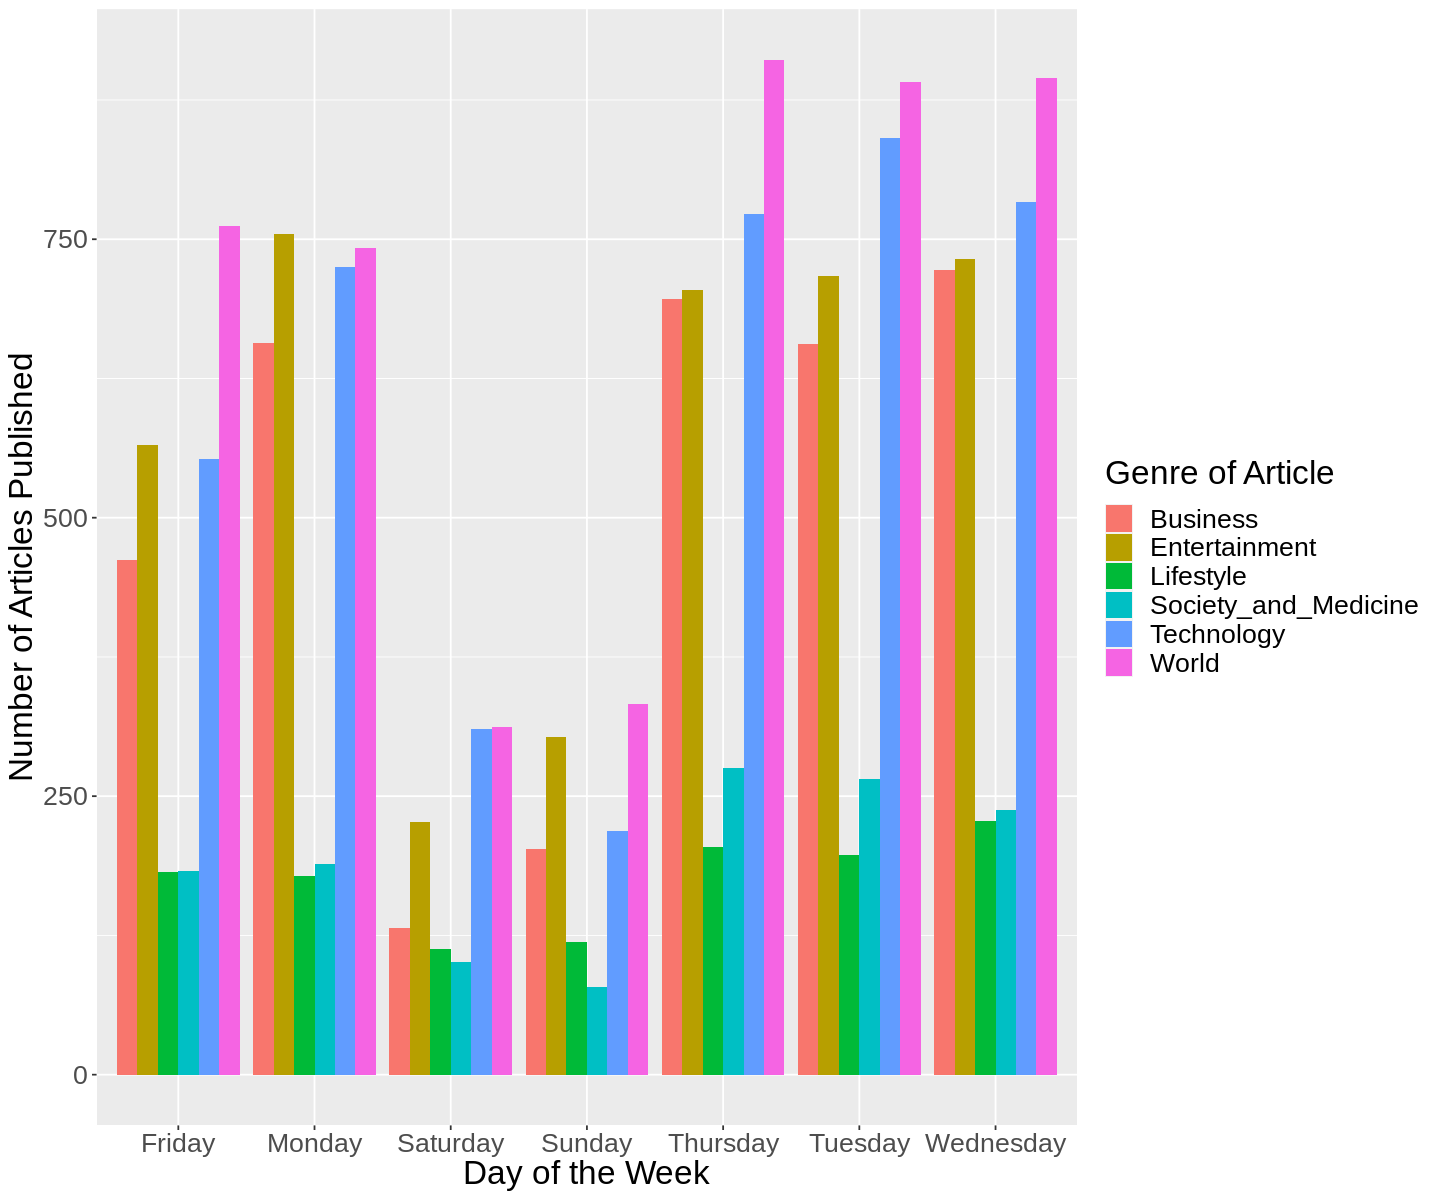

In [8]:
publish_data <- tidy_data %>%
    group_by(Genre, Day_Of_Week) %>%
    summarize(n = n())


options(repr.plot.width = 12, repr.plot.height = 10)
publish_plot <- publish_data %>%
    ggplot(aes(x = Day_Of_Week, y = n, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Number of Articles Published") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

publish_plot

In [10]:
share_data_avg <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), Average_Shares_Per_Article = mean(Shares)/n)

head(share_data_avg)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,Average_Shares_Per_Article
<chr>,<chr>,<int>,<dbl>
Friday,Business,462,5.477460
Friday,Entertainment,565,4.667432
Friday,Lifestyle,182,14.365958
Friday,Society_and_Medicine,183,19.497148
Friday,Technology,553,5.415132
Friday,World,762,2.964734


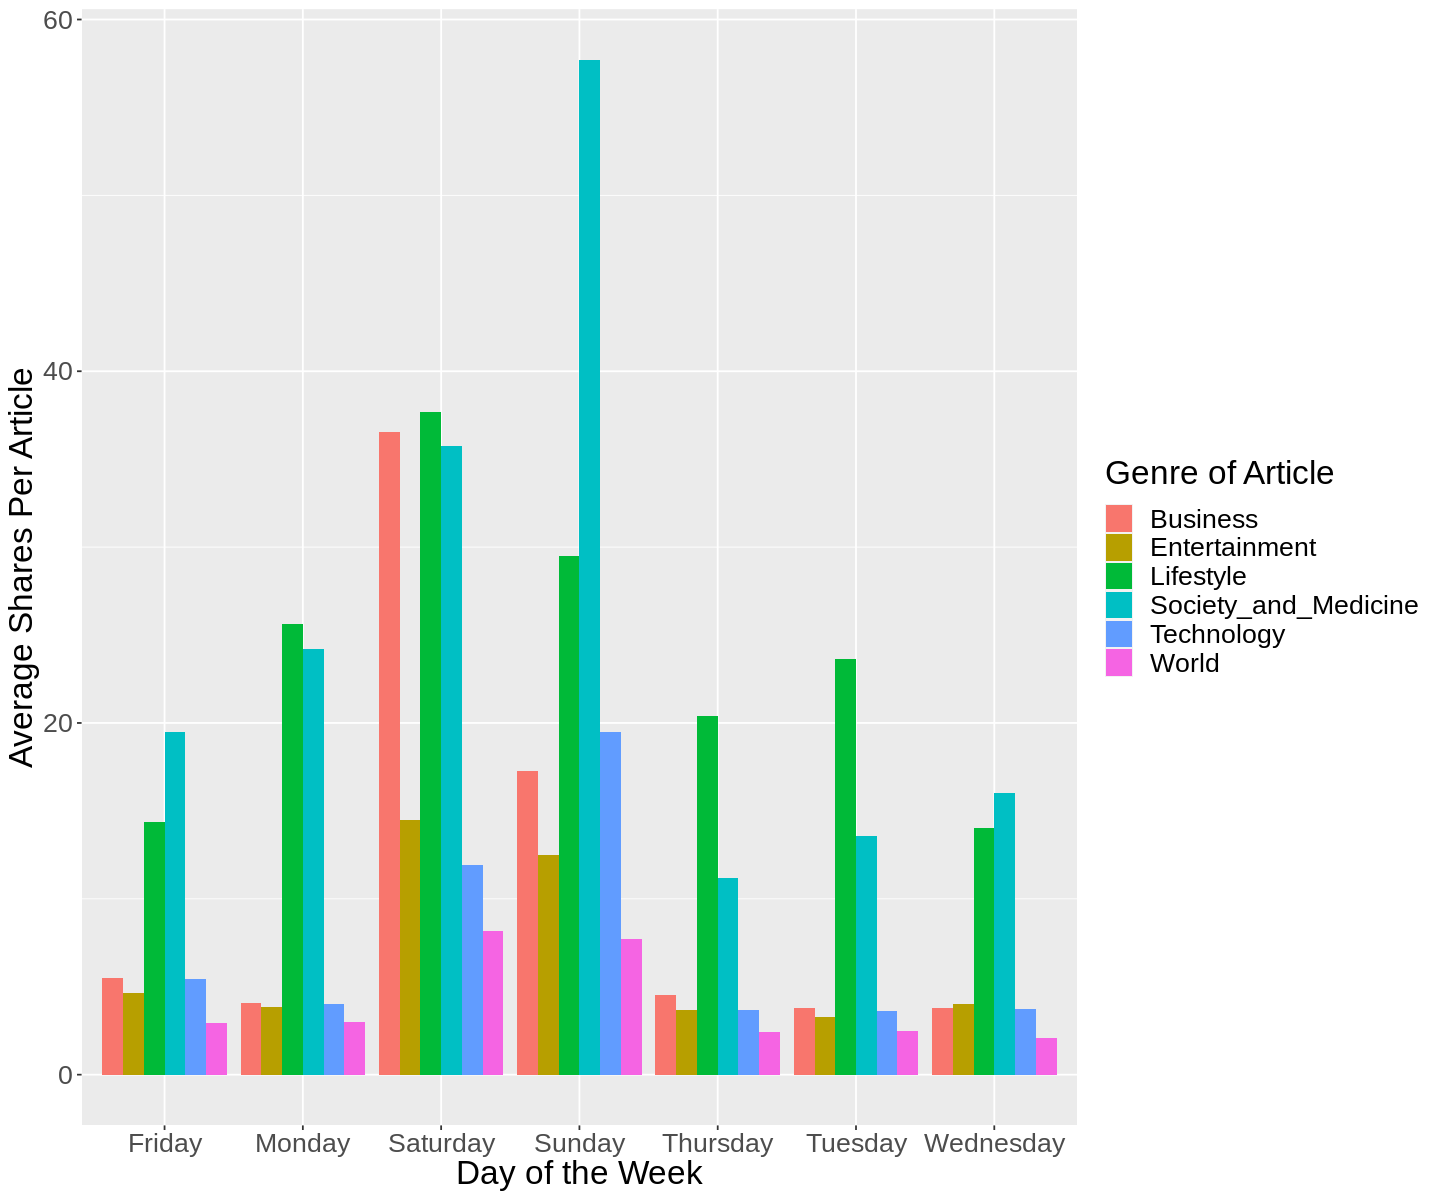

In [11]:



options(repr.plot.width = 12, repr.plot.height = 10)
share_plot <- share_data_avg %>%
    ggplot(aes(x = Day_Of_Week, y = Average_Shares_Per_Article, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Average Shares Per Article") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot

In [13]:
share_data_totals <- tidy_data %>%
    group_by(Day_Of_Week, Genre) %>%
    summarize(n = n(), Shares = sum(Shares))

head(share_data_totals)

`summarise()` regrouping output by 'Day_Of_Week' (override with `.groups` argument)



Day_Of_Week,Genre,n,Shares
<chr>,<chr>,<int>,<dbl>
Friday,Business,462,1169131
Friday,Entertainment,565,1489961
Friday,Lifestyle,182,475858
Friday,Society_and_Medicine,183,652940
Friday,Technology,553,1655996
Friday,World,762,1721455


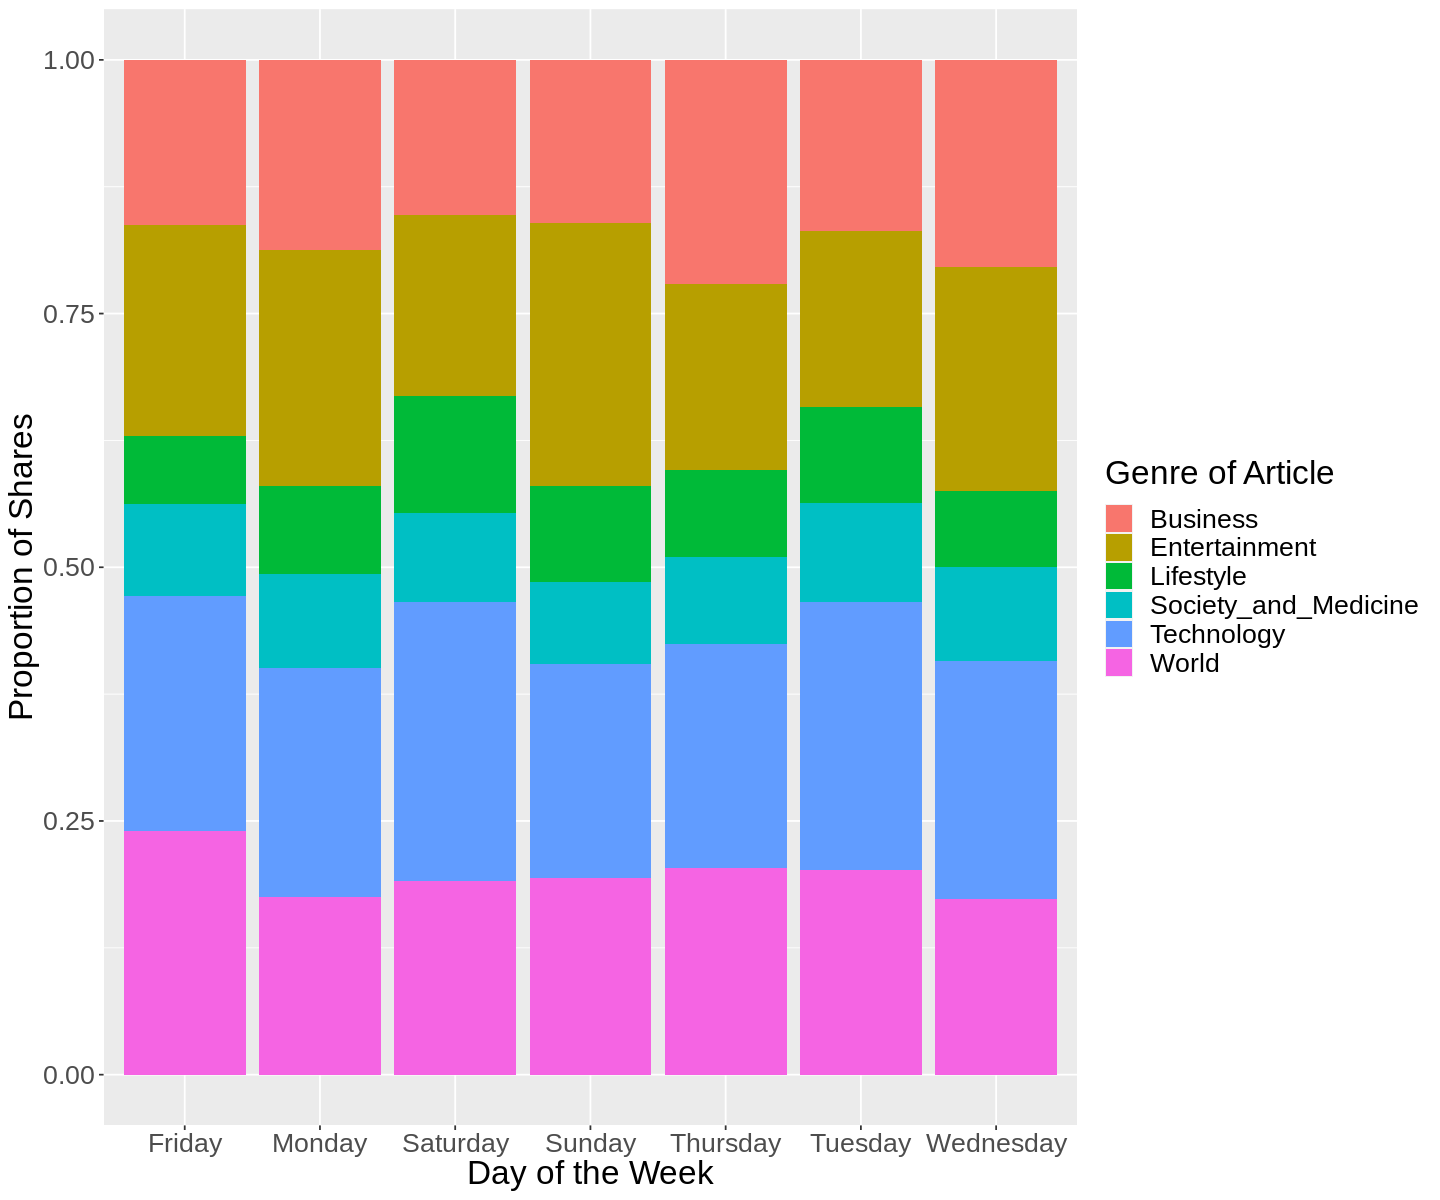

In [14]:



options(repr.plot.width = 12, repr.plot.height = 10)
share_plot_proportion <- share_data_totals %>%
    ggplot(aes(x = Day_Of_Week, y = Shares, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "fill") +
    xlab("Day of the Week") +
    ylab("Proportion of Shares") +
    labs(fill = "Genre of Article") +
    theme(text = element_text(size = 20))

share_plot_proportion

In [16]:
daily_totals <- share_data_totals %>%
    group_by(Day_Of_Week) %>%
    summarize(Total_Shares = sum(Shares))
daily_totals

`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,Total_Shares
<chr>,<dbl>
Friday,7165341
Monday,9382636
Saturday,4173926
Sunday,4425984
Thursday,9887065
Tuesday,9741075
Wednesday,9744778


In [17]:
share_daily_proportions <- share_data_totals %>%
    inner_join(daily_totals) %>%
    mutate(share_proportion = Shares/Total_Shares)
head(share_daily_proportions)

Joining, by = "Day_Of_Week"



Day_Of_Week,Genre,n,Shares,Total_Shares,share_proportion
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
Friday,Business,462,1169131,7165341,0.16316474
Friday,Entertainment,565,1489961,7165341,0.20794000
Friday,Lifestyle,182,475858,7165341,0.06641108
Friday,Society_and_Medicine,183,652940,7165341,0.09112476
Friday,Technology,553,1655996,7165341,0.23111196
Friday,World,762,1721455,7165341,0.24024746


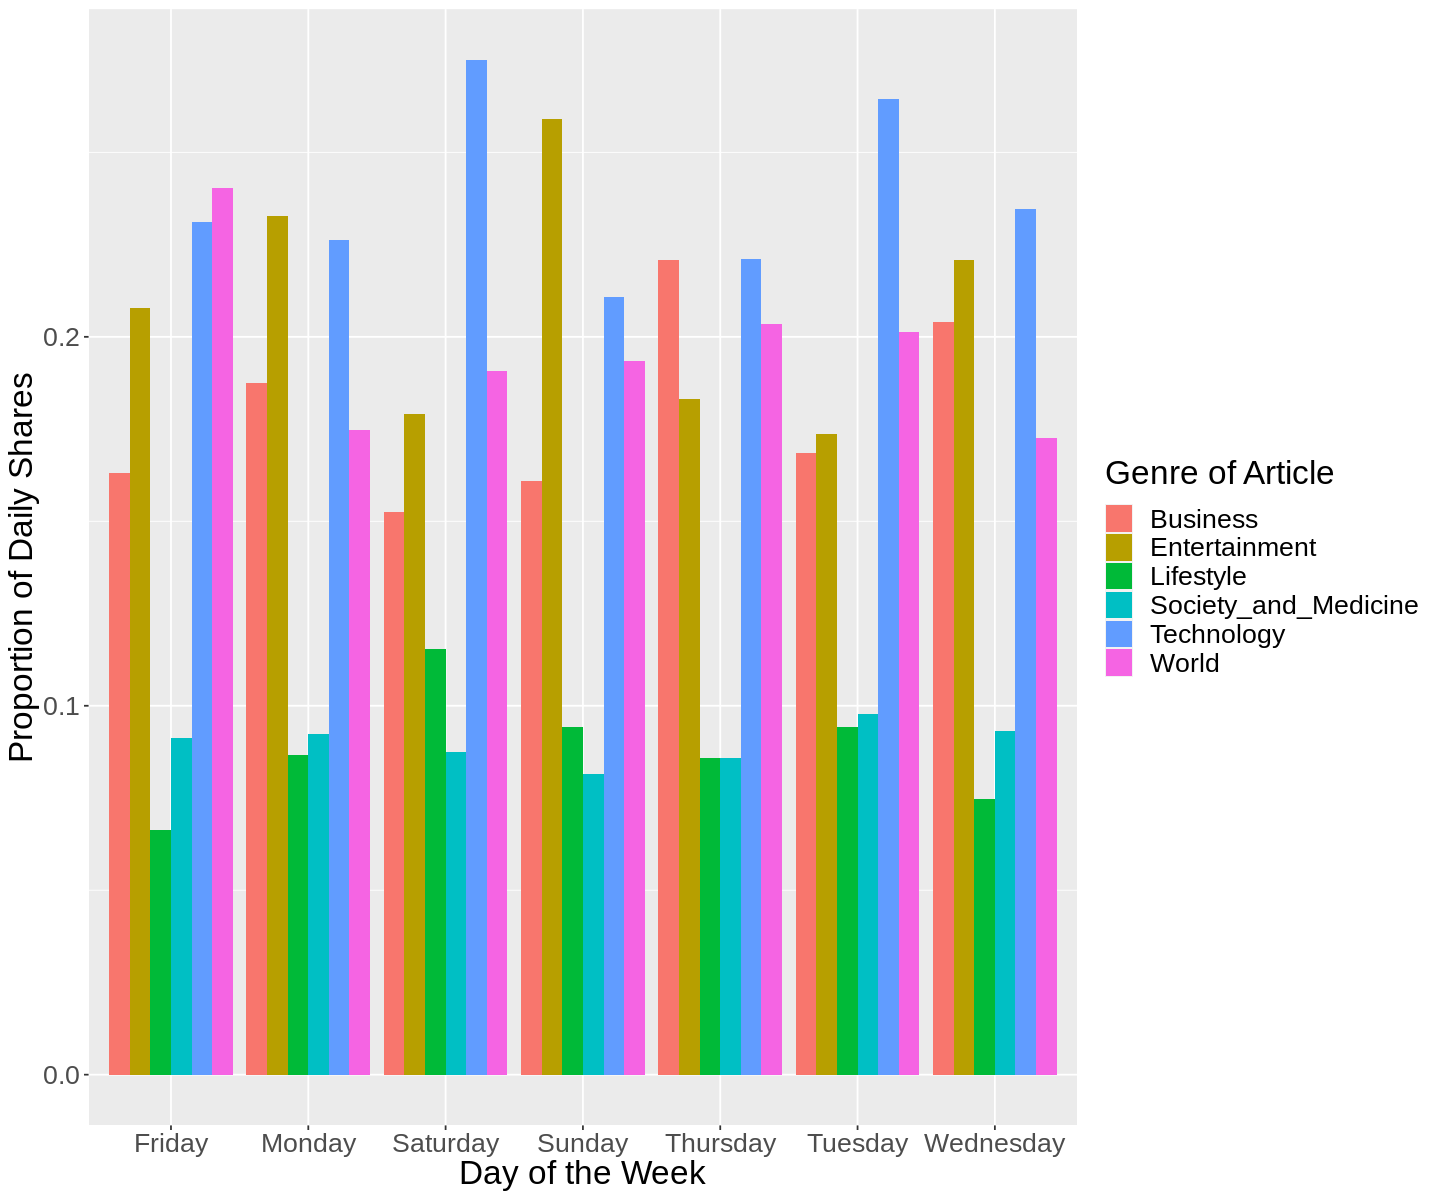

In [18]:
options(repr.plot.width = 12, repr.plot.height = 10)
share_plot_proportioned <- share_daily_proportions %>%
    ggplot(aes(x = Day_Of_Week, y = share_proportion, fill = Genre)) + 
    geom_bar(stat = 'identity', position = "dodge") +
    xlab("Day of the Week") +
    ylab("Proportion of Daily Shares") +
    labs(fill = "Genre of Article") +

    theme(text = element_text(size = 20))

share_plot_proportioned

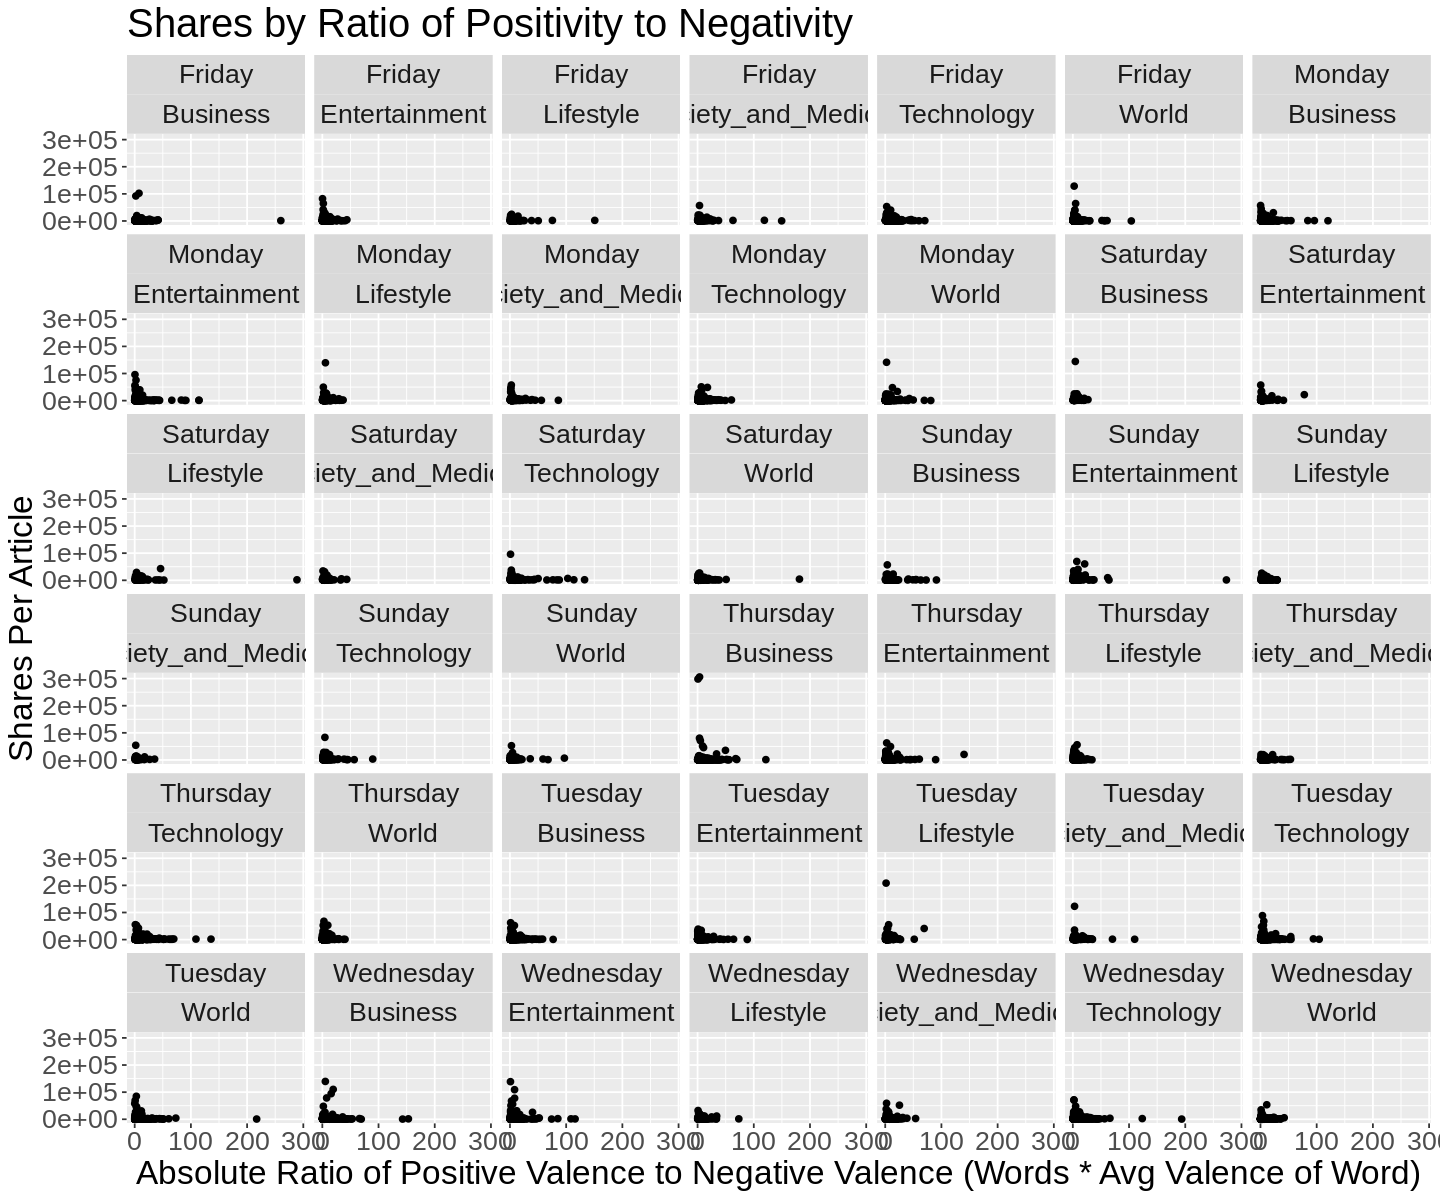

In [20]:
options(repr.plot.width = 12, repr.plot.height = 10)
ratio_plot <- tidy_data %>%
    ggplot(aes(x = abs_pos_neg_ratio, y = Shares)) + 
    geom_point() +
    xlab("Absolute Ratio of Positive Valence to Negative Valence (Words * Avg Valence of Word)") +
    ylab("Shares Per Article") +
    ggtitle("Shares by Ratio of Positivity to Negativity")+
    theme(text = element_text(size = 20))+
    facet_wrap(Day_Of_Week ~ Genre)

ratio_plot
